In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
import skimage
import scipy, scipy.fft
import tifffile
import numba
import imagecodecs
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable #for nice colourbar:)
import matplotlib.collections as collections


from TrackingClasses import dy_dx, add_dy_dx, vector_clustering, plot_cluster_fits, plot_cluster_fits_max, plot_cluster_fits_mean


# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

# Globals

In [44]:
daFileLoc = "/project/ag-raedler/User/Maximilian.Kreft/CutDrifts/220307/"
daFileName = "20220307_24h_softdumbbells_XY30_mcherry_1tif_shortRange.tif"
daFile = daFileLoc + daFileName

micPerPix = 0.333 # microns per pixel 60x 0.108, 100x:0.065, 20x: 0.333, 40x: 163, 333.3 in the 01.09Makro
fPerS = 0.0083 # the fps 11 nikon or 24.99 for tirf at 40ms, once every 10min is 0.0017, once every 2min is 0.0083
beadTypes = ["mCherry", "GFP"]
beadType = beadTypes[0]

save = 2 #1 if not yet analysed 2 if it was
geofilter = 2.7 # check code for what that means
fltrPixl = 0.03
dmode = 5 # diffmode i.e. difference mode
t_neutrals = [45,177,263]

In [47]:
#@pims.pipeline
frames = pims.open(daFile)

if beadType == beadTypes[0]:
    frames_nucl = frames
    nucleusName = daFileName
elif beadType == beadTypes[1]:
    nucleusName = "C1-20220603_softdumbbells_XY07_merged-1_mCherry.tif"
    frames_nucl = pims.open(daFileLoc + nucleusName)
else:
    print("Error in beadtype")

In [4]:
noFrames = len(frames) #for later
frames

<Frames>
Source: /project/ag-raedler/User/Maximilian.Kreft/CutDrifts/220307/20220307_24h_softdumbbells_XY30_mcherry_1tif_shortRange.tif
Length: 277 frames
Frame Shape: (135, 440)
Pixel Datatype: uint16

{'ImageDescription': 'ImageJ=1.53f\nimages=277\nframes=277\nunit=\\u00B5m\nspacing=0.33\nloop=false\nmin=176.0\nmax=3715.0'}
[[1363 1490 1855 ... 1376 1341 1376]
 [1382 1704 2094 ... 1270 1347 1327]
 [1459 1813 2140 ... 1484 1540 1397]
 ...
 [1014 1028 1008 ... 1249 1134 1217]
 [ 964  919  907 ... 1433 1330 1392]
 [ 895  880  857 ... 1580 1519 1600]]


Frame([[1363, 1490, 1855, ..., 1376, 1341, 1376],
       [1382, 1704, 2094, ..., 1270, 1347, 1327],
       [1459, 1813, 2140, ..., 1484, 1540, 1397],
       ...,
       [1014, 1028, 1008, ..., 1249, 1134, 1217],
       [ 964,  919,  907, ..., 1433, 1330, 1392],
       [ 895,  880,  857, ..., 1580, 1519, 1600]], dtype=uint16)
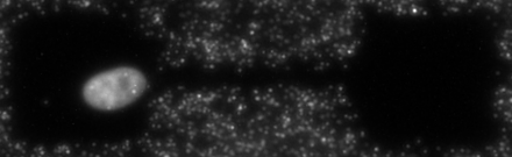

In [5]:
#frames[0].metadata = {'ImageDescription': 'asdfeJ=1.53c\nimages=416\nframes=416\nfinterval=1\nfps=1\nloop=false\nmin=0.0\nmax=255.0'}
print(frames[0].metadata)
print(frames[0])
frames[0]

# 2) locate features

In [68]:
featureSize = 9 # odd integer that says how many pixels the size of our feature is (better overestimate)
# 9 sg 100x, 53 for makroexp, 9 for first2vids
inversionBool = False #set true is feature arent bright but dark

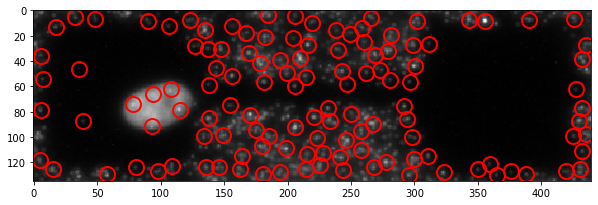

In [69]:
f = tp.locate(frames[0], featureSize, invert=inversionBool)
tp.annotate(f, frames[0]);

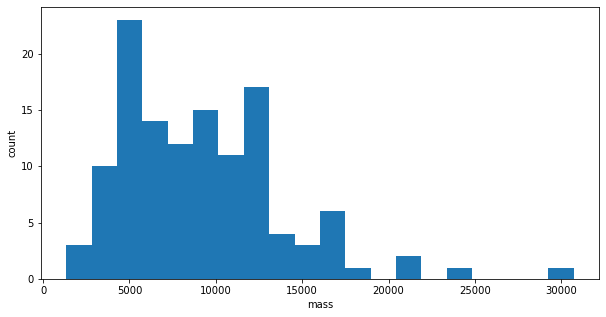

In [8]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
ax.set_xscale("linear")

In [9]:
if beadType == "mCherry":
    featMinmass = 5000 #can still be set to zero if unsure
    featMaxmass = 100*20000 #not used yet
elif beadType == "GFP":
    featMinmass = 1000 #can still be set to zero if unsure
    featMaxmass = 100*20000 #not used yet

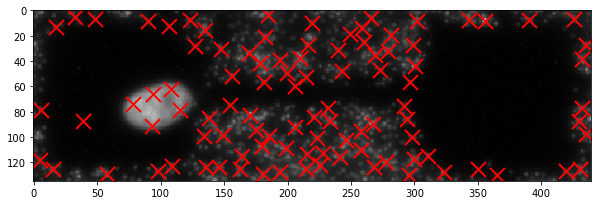

In [11]:
f = tp.locate(frames[0], featureSize, invert=inversionBool, minmass=featMinmass)
f = f[((f['mass'] > featMinmass) & (f['mass'] < featMaxmass))]
tp.annotate(f, frames[0],plot_style=dict(marker='x'));

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

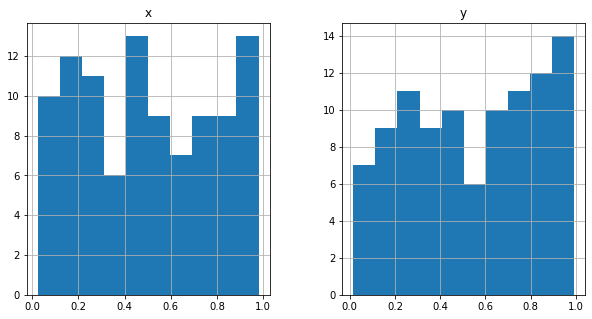

In [12]:
#checking for subpixel bias
tp.subpx_bias(f)
# is good if not concave

In [75]:
# if biggie
if save==1: 
    # or the brute force technique (as opposed to the elegance of the previous approach)
    #it cannot be faster than tp.batch but it never gives errors
    fs = [tp.locate(frames[i], featureSize, invert=inversionBool, minmass=featMinmass, engine="python") for i in range(len(frames[:]))]
    f = pd.concat(fs) #very fast
    f.to_csv(daFile+'_f.txt')
    f.head()
elif save==2:
    f = pd.read_csv(daFile+'_f.txt')  
    f.head() #bit of a difference in numbering it gets extra index but well

# 3) trajectories

In [76]:
maxDisplacement = 6 #how many pixels a feature can maximally jump
maxMemory = 5 #how many frames a feature can disappear
minTrajSize = int(0.3*len(frames)) #set number like 20 or 100 for movement, int(noFrames*0.75) if no movement expected

In [77]:
# tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, maxDisplacement, memory= maxMemory)

# filter out spurious trajectories unter X frames long (this value can be changed)
t1 = tp.filter_stubs(t, minTrajSize)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 805
After: 83


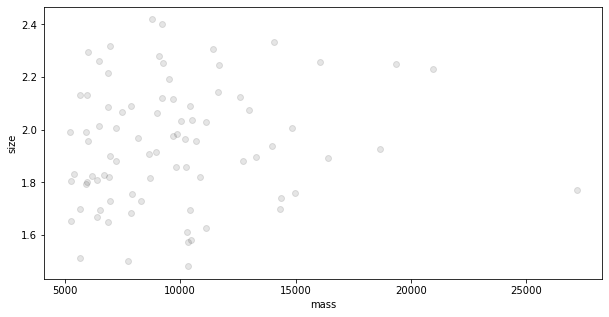

In [17]:
# filter by appearance
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [18]:
featMaxmass = 200000
featMaxSize = 3 # away from main blob
featMaxEccentricity = 0.3

In [19]:
t2 = t1[((t1['mass'] < featMaxmass) & (t1['size'] < featMaxSize) &
         (t1['ecc'] < featMaxEccentricity))]

print('Before:', t1['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 83
After: 77
0.06923838887477483 0.039454676846433945 15744 29563 0.4869859378906882 0.0124261922649522


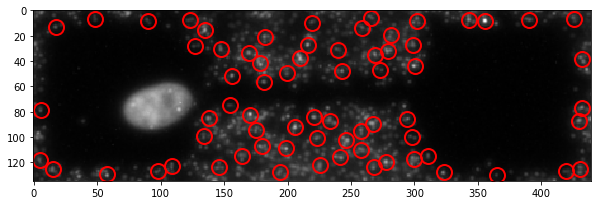

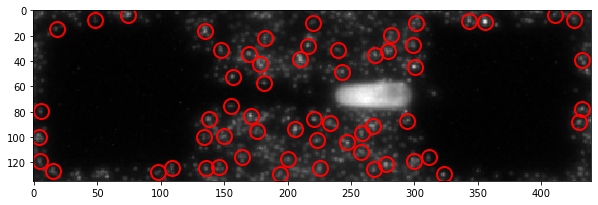

In [20]:
plt.figure()
tp.annotate(t1[t1['frame'] == 0], frames[0]);
plt.figure()
n2 = int(len(frames)/2)
tp.annotate(t2[t2['frame'] == n2], frames[n2]);

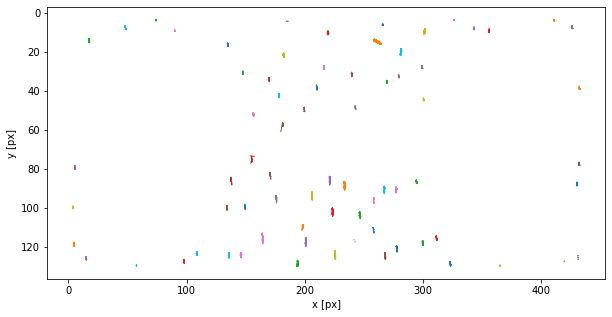

In [21]:
plt.figure()
tp.plot_traj(t2);

# 4) Filtering 

This should honestly be done in an automated way. 

In [22]:
# geofilter = ; #can be defined here but nicer at the top
if geofilter==True:
    xmin, xmax = 100, 280
    ymin, ymax = 20, 110
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
elif geofilter ==2: #20220114 selfcut 
    xmin, xmax = 100, 280
    ymin, ymax = 0, 140
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
elif geofilter ==2.5: #20220211_xy21 selfcut 
    xmin, xmax = 100, 280
    ymin, ymax = 0, 175
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
elif geofilter ==2.6: #20220211_xy17 selfcut 
    xmin, xmax = 100, 280
    ymin, ymax = 0, 175
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
elif geofilter ==2.7: #202200307_xy30 selfcut 20220603 xy07
    xmin, xmax = 100, 300
    ymin, ymax = 0, 175
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
elif geofilter ==2.8: #202200307_xy09 selfcut 20220603 xy03-2
    xmin, xmax = 100, 350
    ymin, ymax = 0, 175
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
elif geofilter ==2.9: #202200416_xy06 xy02 selfcut 
    xmin, xmax = 110, 320
    ymin, ymax = 0, 175
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
elif geofilter==3: #custom boundaries for single particle tracking
    xmin, xmax = 120, 160
    ymin, ymax = 30, 50
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
elif geofilter==3.1: #20220603 xy20 1 xy03-1 
    xmin, xmax = 110, 350
    ymin, ymax = 0, 200
    t3 = t2[((t2['x'] > xmin) & (t2['x'] < xmax) & (t2['y'] > ymin) & (t2['y'] < ymax))]
else:
    t3 = t2[:]
t3

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,,
0,90,110.223724,257.924148,10388.554271,2.050438,0.297139,675.446104,103008.0,0.042943,0,1
0,89,108.947531,198.539162,15263.449743,1.838732,0.269567,1356.513291,110974.0,0.038816,0,2
0,87,102.420054,246.134577,18096.850797,2.280875,0.221035,1083.203698,126540.0,0.032678,0,4
0,86,100.442433,223.277370,11103.930889,1.888326,0.164916,867.770450,85052.0,0.056482,0,5
0,81,99.253419,133.905398,7137.194396,1.990549,0.070683,497.903126,70002.0,0.076768,0,9
...,...,...,...,...,...,...,...,...,...,...,...
276,39,36.134399,269.207490,9344.436485,2.103330,0.222568,737.917784,81949.0,0.045679,276,95
276,38,35.180278,169.855854,7364.144709,1.449031,0.149327,853.039065,74899.0,0.052059,276,96
276,37,33.411950,279.479853,13887.562257,2.064394,0.135325,909.421612,88932.0,0.040735,276,97


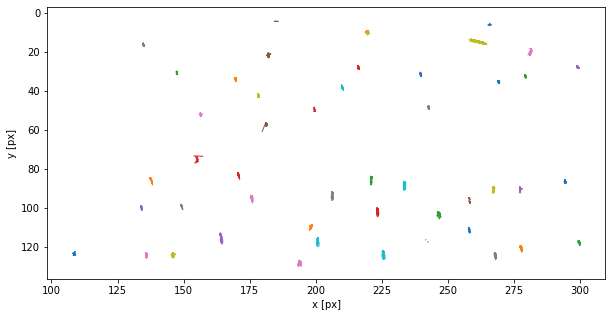

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [23]:
tp.plot_traj(t3)

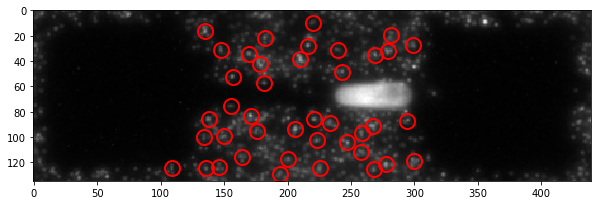

In [24]:
tp.annotate(t3[t3['frame'] == n2], frames[n2]);

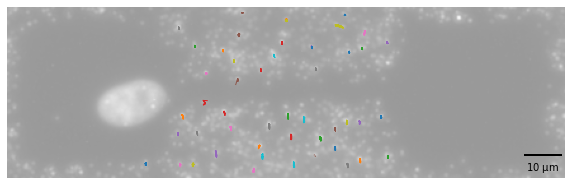

In [25]:
fig, ax = plt.subplots()
ax.axis("off")
ax.add_artist(ScaleBar(dx=0.33e-6, units="m",fixed_value=10,fixed_units="um", box_alpha=0, location="lower right"))
ax.imshow(frames[0], alpha=0.4)
tp.plot_traj(t3);
fig.savefig(daFile + "_trajes.png")

# 5) Analysis

Here a lot more is going on the the not streamlined version if you are interested in looking at drifts and stuff

In [26]:
# if biggie
if save==1: 
    t4 = add_dy_dx(t3, dmode, fltrPixl, 0, t_neutrals)
    t4.to_csv(daFile+f'_t4_diffmode{dmode}.txt')
    t4.head()
elif save==2: 
    t4 = pd.read_csv(daFile+f'_t4_diffmode{dmode}.txt', index_col="frame_index")  
    t4.head() #bit of a difference in numbering it gets extra index but well

# 6) Presentation

calibrate the further process with a single frame
check for a good picno (where nucleus in the middle) what maximum relevant displacement borders (maxrel minrel) you have


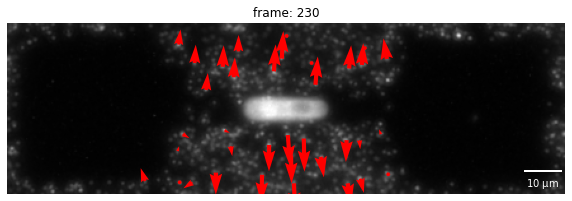

In [29]:
picno = 230
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(frames[picno])
ax.quiver(t4.loc[picno]["x"],t4.loc[picno]["y"],t4.loc[picno]["dx"],-t4.loc[picno]["dy"], color="red", scale=40)
#ax.quiver(t4.loc[t4["frame_index"]==picno]["x"],t4.loc[t4["frame_index"]==picno]["y"],t4.loc[t4["frame_index"]==picno]["dx"],-t4.loc[t4["frame_index"]==picno]["dy"], color="red", scale=40)
ax.add_artist(ScaleBar(dx=0.33e-6, units="m",fixed_value=10,fixed_units="um", box_alpha=0, location="lower right", color="white"))
ax.set_title("frame: " + str(picno))
plt.show()
fig.savefig(daFile + "_frame_"+str(picno)+".png", dpi=600)

0.4795757087624576 0.18716142253964035


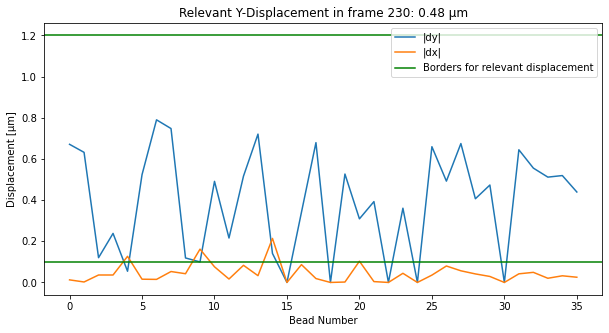

In [30]:
#disps = ((abs(t4.loc[picno]["dx"].unique()))**2 + ((abs(t4.loc[picno]["dy"].unique())))**2)**0.5 * micPerPix
#disps = disps[disps > 0.1]
#print(np.mean(disps), np.std(disps))

disps_y = abs(t4.loc[picno]["dy"].values) * micPerPix
#disps_y = abs(t4.loc[t4["frame_index"]==picno]["dy"].values) * micPerPix
maxrel = 1.2
minrel = 0.1
disps_y = disps_y[(maxrel > disps_y)]
disps_y = disps_y[(disps_y> minrel)]
print(np.mean(disps_y), np.std(disps_y))

plt.plot(abs(t4.loc[picno]["dy"].values * micPerPix), label="|dy|")
plt.plot(abs(t4.loc[picno]["dx"].values * micPerPix), label="|dx|")
#plt.plot(abs(t4.loc[t4["frame_index"]==picno]["dy"].values * micPerPix), label="|dy|")
#plt.plot(abs(t4.loc[t4["frame_index"]==picno]["dx"].values * micPerPix), label="|dx|")
plt.axhline(maxrel, label="Borders for relevant displacement", color="green")
plt.axhline(minrel, color="green")
plt.title("Relevant Y-Displacement in frame "+str(picno)+": "+ str(np.round(np.mean(disps_y),2))+" µm")
plt.legend()
plt.ylabel("Displacement [µm]")
plt.xlabel("Bead Number")
plt.savefig(daFile + "_disps_atFrame_"+str(picno)+".png", dpi=300)
plt.show()

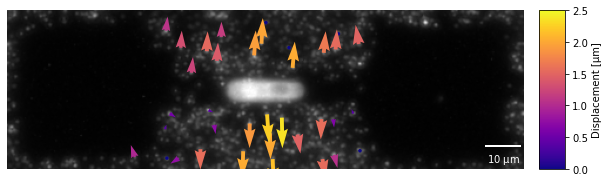

In [33]:
# with scalebar

fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(frames[picno])

colours = [ np.sqrt( ( t4.loc[i]["dx"] )**2 + ( t4.loc[i]["dy"] )**2 ) for i in range(len(frames))]
colours_arr = np.concatenate(colours).ravel()
maxcolour = colours_arr.max() #doesnt work bc of outliers
maxcolour = 2.5

colour = np.sqrt( ( t4.loc[picno]["dx"] )**2 + ( t4.loc[picno]["dy"] )**2 )
norm = mpl.colors.Normalize(vmin=0, vmax=maxcolour)
Q = ax.quiver(t4.loc[picno]["x"],t4.loc[picno]["y"],t4.loc[picno]["dx"],-t4.loc[picno]["dy"],
               colour,
                cmap="plasma", norm=norm, scale=40)


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = fig.colorbar(Q, cax=cax)
cbar.set_label("Displacement [µm]")


ax.add_artist(ScaleBar(dx=0.33e-6, units="m",fixed_value=10,fixed_units="um", box_alpha=0, location="lower right", color="white"))
#ax.set_title("frame: " + str(picno))
plt.show()
fig.savefig(daFile + "_frame_"+str(picno)+"_scalebar.png", dpi=600, pad_inches=0, bbox_inches='tight', transparent=True)


In [34]:
disps_y = abs(t4.loc[picno]["dy"].unique()) * micPerPix
disps_y

array([0.67078965, 0.63178853, 0.12029753, 0.23811079, 0.05438792,
       0.52334065, 0.78970944, 0.74741339, 0.11893151, 0.09967081,
       0.49093992, 0.21574464, 0.51627729, 0.7203622 , 0.1407192 ,
       0.        , 0.3409094 , 0.67895522, 0.52644035, 0.30889781,
       0.39263499, 0.3605527 , 0.65923074, 0.49208146, 0.67458638,
       0.4065035 , 0.47306459, 0.64430573, 0.55528   , 0.51150452,
       0.51908177, 0.43924168])

## Video of Disps

make displacement videos (always takes a while)

    all red
    
    all with colour but no scalebar
    
    length of arrow not dx dy but actualldy the forces (important)

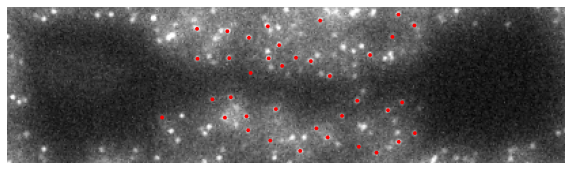

In [115]:
# works but only saves as gif, so conversion needed afterwards but thats fast.
fig = plt.figure()
plt.axis("off")
ims = []

for i in range(len(frames)):
#for i in range(74):
    im1 = plt.imshow(frames[i], animated=True)
    try:
        im2 = plt.quiver(t4.loc[i]["x"],t4.loc[i]["y"],t4.loc[i]["dx"],-t4.loc[i]["dy"], color="red", scale=20, animated=True)
        #im2 = plt.quiver(t4.loc[t4["frame_index"]==picno]["x"], 
         #                t4.loc[t4["frame_index"]==picno]["y"], 
          #               t4.loc[t4["frame_index"]==picno]["dx"], 
           #              -t4.loc[t4["frame_index"]==picno]["dy"], color="red", scale=20, animated=True)
    except:
        im2 = im1
    ims.append([im1, im2])
    # found this solution here https://stackoverflow.com/questions/41918576/python-imshow-how-to-get-merge-two-class-matplotlib-image-axesimage-into-on

ani = mpl.animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat_delay=1000)

#fileloc = "C:\\Users\\m.kreft\\PycharmProjects\\Tracker\\pics\\" + daFileName + "_diffmode3_scale40.gif"
fileloc = daFileLoc + daFileName + "_diffmode5_scale20_001um_noaxes.gif"
writervideo = mpl.animation.PillowWriter(fps=3) 
ani.save(fileloc, writer=writervideo)

plt.show()

## Video of Discps with Colour

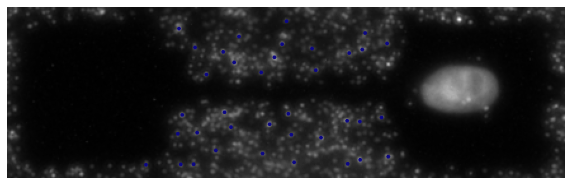

In [85]:
# works but only saves as gif, so conversion needed afterwards but thats fast.
fig = plt.figure()
plt.axis("off")
ims = []
colours = [ np.sqrt( ( t4.loc[i]["dx"] )**2 + ( t4.loc[i]["dy"] )**2 ) for i in range(len(frames))]
colours_arr = np.concatenate(colours).ravel()
maxcolour = colours_arr.max() #doesnt work bc of outliers
maxcolour = 2.5
for i in range(len(frames)):
#for i in range(74):
    im1 = plt.imshow(frames[i], animated=True)
    try:
        colour = np.sqrt( ( t4.loc[i]["dx"] )**2 + ( t4.loc[i]["dy"] )**2 )
        norm = mpl.colors.Normalize(vmin=0, vmax=maxcolour)
        im2 = plt.quiver(t4.loc[i]["x"],t4.loc[i]["y"],t4.loc[i]["dx"],-t4.loc[i]["dy"],colour,cmap="plasma", norm=norm, scale=40)
        #im2 = plt.quiver(t4.loc[i]["x"],t4.loc[i]["y"],t4.loc[i]["dx"],-t4.loc[i]["dy"], color="red", scale=20, animated=True)
        #im2 = plt.quiver(t4.loc[t4["frame_index"]==picno]["x"], 
         #                t4.loc[t4["frame_index"]==picno]["y"], 
          #               t4.loc[t4["frame_index"]==picno]["dx"], 
           #              -t4.loc[t4["frame_index"]==picno]["dy"], color="red", scale=20, animated=True)
    except:
        im2 = im1
    ims.append([im1, im2])
    # found this solution here https://stackoverflow.com/questions/41918576/python-imshow-how-to-get-merge-two-class-matplotlib-image-axesimage-into-on

ani = mpl.animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat_delay=1000)

#fileloc = "C:\\Users\\m.kreft\\PycharmProjects\\Tracker\\pics\\" + daFileName + "_diffmode3_scale40.gif"
fileloc = daFileLoc + daFileName + "_diffmode5_scale20_001um_noaxes_colours.gif"
writervideo = mpl.animation.PillowWriter(fps=3) 
ani.save(fileloc, writer=writervideo)

plt.show()


## Video of Forces

first two good to do in general

last ones just video

In [39]:
def hertz_force(disp = 0.4e-6, bridgewidth_initial=7e-6, D_initial=13e-6, E_gel=2.7e3,  nu_gel=0.5):
    sign=1
    if disp<0:
        sign=-1
    h = np.array(np.abs(disp)*1e-6 + bridgewidth_initial)
    #print(disp, h)
    f = 4/3 * (E_gel/1-nu_gel**2) * D_initial**0.5 * (h/2 - bridgewidth_initial/2)**(3/2)
    return sign*f

In [40]:
t4_forces = t4.copy()
fx = lambda row: hertz_force(row.dx)*1e9
fy = lambda row: hertz_force(row.dy)*1e9
t4_forces['fx'] = t4_forces.apply(fx, axis=1)
t4_forces['fy'] = t4_forces.apply(fy, axis=1)

In [41]:
t4_forces.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,dy,dx,fx,fy
frame_index,,,,,,,,,,,,,,
0,110.223724,257.924148,10388.554271,2.050438,0.297139,675.446104,103008.0,0.042943,0,1,0.000000,0.000000,0.000000,0.000000
0,108.947531,198.539162,15263.449743,1.838732,0.269567,1356.513291,110974.0,0.038816,0,2,-0.020280,-0.123621,-0.199447,-0.013252
0,102.420054,246.134577,18096.850797,2.280875,0.221035,1083.203698,126540.0,0.032678,0,4,0.409037,0.680514,2.575993,1.200419
0,100.442433,223.277370,11103.930889,1.888326,0.164916,867.770450,85052.0,0.056482,0,5,-0.045341,-0.050747,-0.052458,-0.044302
0,99.253419,133.905398,7137.194396,1.990549,0.070683,497.903126,70002.0,0.076768,0,9,-0.133231,0.049640,0.050750,-0.223149


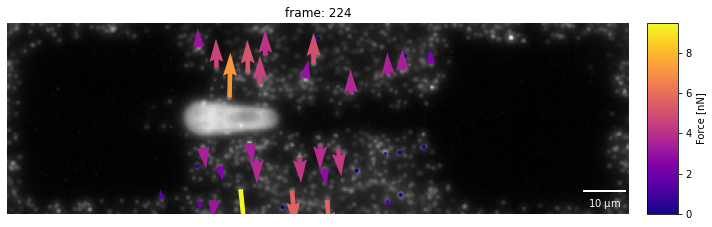

In [37]:
# gives you a force plot of one frame
picno = 224 # defined again here but unnesessary


fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(frames[picno])
#ax.quiver(t4.loc[picno]["x"],t4.loc[picno]["y"],t4.loc[picno]["dx"],-t4.loc[picno]["dy"], color="red", scale=40)
# norm = mpl.colors.Normalize(t4_forces["fy"].max()),
colour = np.sqrt( ( t4_forces.loc[picno]["fx"] )**2 + ( t4_forces.loc[picno]["fy"] )**2 )
Q = ax.quiver(t4.loc[picno]["x"],t4.loc[picno]["y"],t4_forces.loc[picno]["fx"],-t4_forces.loc[picno]["fy"],
               colour,
                cmap="plasma", scale=100)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = fig.colorbar(Q, cax=cax)
cbar.set_label("Force [nN]")


ax.add_artist(ScaleBar(dx=0.33e-6, units="m",fixed_value=10,fixed_units="um", box_alpha=0, location="lower right", color="white"))
ax.set_title("frame: " + str(picno))
fig.tight_layout()
plt.show()
fig.savefig(daFile + "_frame_"+str(picno)+".png", dpi=600)

(array([4.000e+00, 5.000e+00, 1.200e+01, 1.300e+01, 1.600e+01, 1.700e+01,
        2.300e+01, 3.400e+01, 4.100e+01, 7.100e+01, 1.000e+02, 1.190e+02,
        1.690e+02, 2.010e+02, 2.310e+02, 3.290e+02, 6.270e+02, 2.700e+03,
        3.805e+03, 6.490e+02, 2.210e+02, 1.870e+02, 1.580e+02, 1.190e+02,
        1.170e+02, 1.030e+02, 7.600e+01, 5.100e+01, 3.900e+01, 3.600e+01,
        2.700e+01, 2.400e+01, 2.300e+01, 2.100e+01, 2.000e+01, 1.200e+01,
        9.000e+00, 7.000e+00, 4.000e+00, 1.000e+00]),
 array([-14.95629072, -14.12830731, -13.30032389, -12.47234047,
        -11.64435706, -10.81637364,  -9.98839023,  -9.16040681,
         -8.3324234 ,  -7.50443998,  -6.67645657,  -5.84847315,
         -5.02048974,  -4.19250632,  -3.36452291,  -2.53653949,
         -1.70855608,  -0.88057266,  -0.05258925,   0.77539417,
          1.60337758,   2.431361  ,   3.25934441,   4.08732783,
          4.91531124,   5.74329466,   6.57127807,   7.39926149,
          8.2272449 ,   9.05522832,   9.88321174,  10.

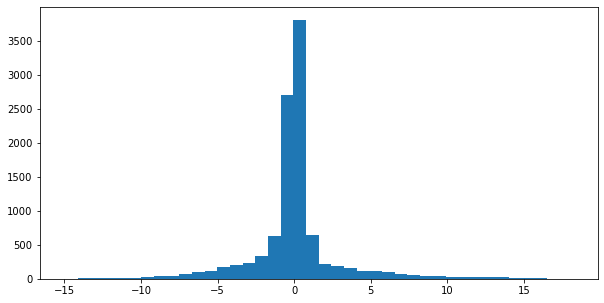

In [42]:
plt.hist(t4_forces["fy"], bins=40)

In [ ]:
# produces the whole video but without the intensity bar (seldom needed)
# works but only saves as gif, so conversion needed afterwards but thats fast.
fig, ax = plt.subplots()
plt.axis("off")
ims = []

t4_forces = t4.copy()
fx = lambda row: hertz_force(row.dx)*1e9
fy = lambda row: hertz_force(row.dy)*1e9
t4_forces['fx'] = t4_forces.apply(fx, axis=1)
t4_forces['fy'] = t4_forces.apply(fy, axis=1)


for i in range(len(frames)):
#for i in range(4):
    im1 = plt.imshow(frames[i], animated=True)
    try:
        colour = np.sqrt( ( t4_forces.loc[i]["fx"] )**2 + ( t4_forces.loc[i]["fy"] )**2 )
        im2 = plt.quiver(t4.loc[i]["x"],t4.loc[i]["y"],t4.loc[i]["fx"],-t4.loc[i]["fy"], color="red", scale=20, animated=True)
        #im2 = plt.quiver(t4.loc[t4["frame_index"]==i]["x"], 
        #                 t4.loc[t4["frame_index"]==i]["y"], 
        #                 t4_forces.loc[t4["frame_index"]==i]["fx"], 
        #                 -t4_forces.loc[t4["frame_index"]==i]["fy"], colour, cmap="plasma", scale=100)
    except:
        im2 = im1
    ims.append([im1, im2])
  # found this solution here https://stackoverflow.com/questions/41918576/python-imshow-how-to-get-merge-two-class-matplotlib-image-axesimage-into-on

#divider = make_axes_locatable(plt.gca())
#cax = divider.append_axes("right", "5%", pad="3%")
#cbar = plt.colorbar(im2)
#cbar.set_label("Force [nN]")

ani = mpl.animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat_delay=1000)

#fileloc = "C:\\Users\\m.kreft\\PycharmProjects\\Tracker\\pics\\" + daFileName + "_diffmode3_scale40.gif"
fileloc = daFileLoc + daFileName + "_diffmode5_scale20_001um_noaxes_forces.gif"
writervideo = mpl.animation.PillowWriter(fps=20) 
ani.save(fileloc, writer=writervideo)

plt.show()

In [ ]:
ims

# E(t)

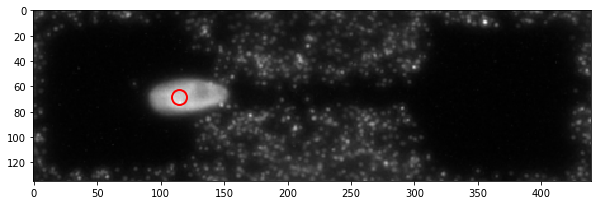

In [53]:
# check that only nuclue sis tracked 

featureSize = int(14/0.33+1)
featMinmass = 500000


n = len(frames_nucl)
avg = frames_nucl[0] / n
for i in range(1, n): 
    avg = avg + frames_nucl[i] / n
avg

f_test = tp.locate(frames_nucl[180]-avg, featureSize, invert=inversionBool, minmass=featMinmass, engine="numba")
tp.annotate(f_test, frames_nucl[180]);

In [54]:
#ncleus track
if nucleusName in ["C1-20220416_24h_ softdumbbells006_XY06_short_mCherry.tif", "C1-20220416_24h_ softdumbbells006_XY02_mCherry.tif"]:
    featureSize = int(14/0.33+1)
    featMinmass = 500000/2
elif nucleusName in [ "20220603_softdumbbells_XY20_mcherry-1.tif"]:
    featureSize = int(24/0.33+1)
    featMinmass = 50000000/2
elif nucleusName in ["C1-20220114_softdumbbells_XY03_merged-1_mCherry.tif", "C1-20220114_softdumbbells_XY03_merged-2_mCherry.tif"]:
    featureSize = int(14/0.33+1)
    featMinmass = 5000000
elif nucleusName in ["C1-20220603_softdumbbells_XY07_merged-1_mCherry.tif"]:
    featureSize = int(16/0.33+1)
    featMinmass = 5000000

    
n = len(frames_nucl)
avg = frames_nucl[0] / n
for i in range(1, n): 
    avg = avg + frames_nucl[i] / n
avg

fs = [tp.locate(frames_nucl[i]-avg, featureSize, invert=inversionBool, minmass=featMinmass, engine="numba") for i in range(len(frames[:]))]
f = pd.concat(fs) #very fast

#############trajectories

maxDisplacement = 100 #how many pixels a feature can maximally jump
maxMemory = 20 #how many frames a feature can disappear
minTrajSize = len(frames_nucl)/10 #set number like 20 or 100 for movement, int(noFrames*0.75) if no movement expected


tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, maxDisplacement, memory= maxMemory)

# filter out spurious trajectories unter X frames long (this value can be changed)
t_nucleus = tp.filter_stubs(t, minTrajSize)


Maximum Large Timescale slope: 0.00035334549478115536 um/min
Maximum Short Timescale slope: 0.0004136789501289608 um/min
Maximum Short Timescale slope: -0.0005024298024349813 um/min
Maximum Short Timescale slope: -0.0003046360341500519 um/min
Maximum Short Timescale slope: 0.0021389192920737462 um/min
Maximum Short Timescale slope: 0.000907837045957493 um/min
Maximum Short Timescale slope: 0.0009392597378911925 um/min
Mean Long Timescale slope: 0.00017924972112026022 um/min
Mean Short Timescale slope: -0.00012051430208519748 um/min
Mean Short Timescale slope: -0.0005269691437677359 um/min
Mean Short Timescale slope: -0.0004774366034186155 um/min
Mean Short Timescale slope: 0.0009212614926341174 um/min
Mean Short Timescale slope: 0.0003865032395919287 um/min
Mean Short Timescale slope: 0.0004102633960993545 um/min
/project/ag-raedler/User/Maximilian.Kreft/CutDrifts/220307/20220307_24h_softdumbbells_XY30_mcherry_1tif_shortRange.tif  Done
hi


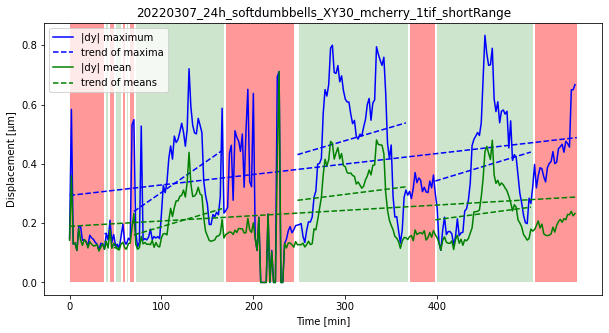

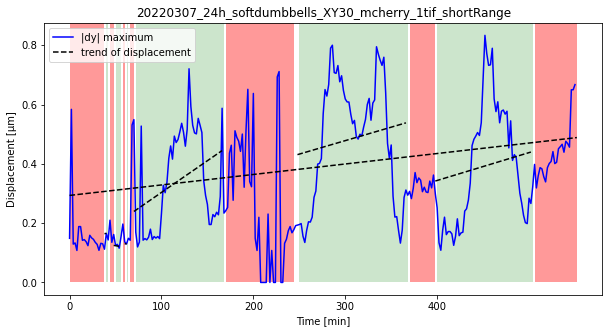

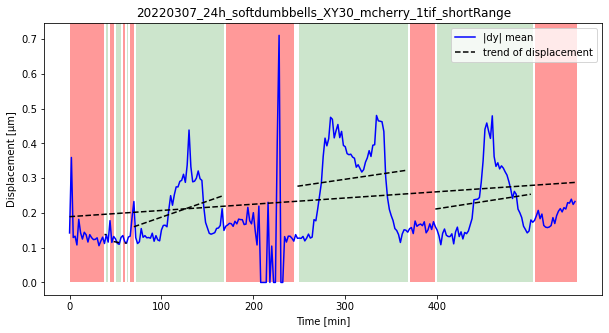

In [56]:
ta = int(0)
if len(t_nucleus["particle"].unique()) > 1:
    te = int(t_nucleus[t_nucleus["particle"] > 0]["frame"].min())
else:
    te = int(len(frames_nucl))

y_disps = np.zeros((te-ta,2)) # first column max second mean
x_disps = np.zeros((te-ta,2))
for ind, picno in enumerate(range(ta, te)):
    try: 
        disps_y = abs(t4.loc[picno]["dy"].values) * micPerPix
    except AttributeError: 
        disps_y = abs(t4.loc[picno]["dy"]) * micPerPix
    #maxrel = 1.4 # take maxrel and minrel like found before
    #minrel = 0.1
    disps_y = disps_y[(maxrel > disps_y)]
    disps_y = disps_y[(disps_y> minrel)]
    if disps_y.size !=0:
        y_disps[ind,0] = disps_y.max()
        y_disps[ind,1] = disps_y.mean()
    try:
        disps_x = abs(t4.loc[picno]["dx"].values) * micPerPix
    except AttributeError:
        disps_x = abs(t4.loc[picno]["dx"]) * micPerPix
    maxrel_x = maxrel # used to be different
    minrel_x = minrel
    disps_x = disps_x[(maxrel_x > disps_x)]
    disps_x = disps_x[(disps_x> minrel_x)]
    if disps_x.size !=0:
        x_disps[ind,0] = disps_x.max()
        x_disps[ind,1] = disps_x.mean()

################## Plotting
x = np.arange(ta, te)


nucl_x = t_nucleus["x"]
in_bridge = (((nucl_x > xmin) & (nucl_x < xmax)).values)


try:
    plot_cluster_fits(x, y_disps, in_bridge, daFile, 1)
    plot_cluster_fits_max(x, y_disps, in_bridge, daFile, 0)
    plot_cluster_fits_mean(x, y_disps, in_bridge, daFile, 0)
    print(daFile, " Done")
except:
    print(daFile, " Error encountered in Plots so skipped")
print("hi")
plt.show()

array([0.58374378, 0.53085645, 0.54915145, 0.5272845 , 0.3275339 ,
       0.30264682, 0.33860035, 0.41874241, 0.4602876 , 0.41591213,
       0.49349227, 0.47184313, 0.48187069, 0.50771698, 0.53669628,
       0.50655155, 0.45948138, 0.51668202, 0.7205441 , 0.59284419,
       0.52988693, 0.50431942, 0.50095989, 0.55330845, 0.53014267,
       0.50539278, 0.34231636, 0.58743945, 0.43604938, 0.46274215,
       0.51140618, 0.4892205 , 0.47646004, 0.44198618, 0.50037691,
       0.32105865, 0.51234833, 0.65130141, 0.34032943, 0.32278515,
       0.63739017, 0.69312286, 0.7112157 , 0.30814583, 0.39904077,
       0.4016088 , 0.41760115, 0.56906803, 0.65044362, 0.62852426,
       0.66768213, 0.79021373, 0.80002358, 0.70759516, 0.70508712,
       0.73142769, 0.67672946, 0.6969848 , 0.647653  , 0.61869851,
       0.60885916, 0.60834072, 0.56743985, 0.53526236, 0.54644827,
       0.49296654, 0.48350171, 0.49986094, 0.49389618, 0.52390585,
       0.5494481 , 0.60001403, 0.62067463, 0.54705297, 0.60508

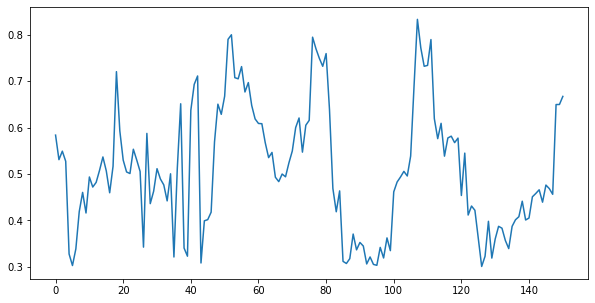

In [64]:
a = y_disps[:-1,0]
a = a[a>0.3]
#a = a[a<0.99]

plt.plot(a)
data_path = "/project/ag-raedler/User/Maximilian.Kreft/CutDrifts/disps/"
np.save(data_path + daFileName + ".npy", a)
a

# Final DataTable Save

used for Friction Coeff and in general best practise

In [54]:
# have to get t4_forces and in_bridge from code before!

In [58]:
t4_forcesave = t4_forces.copy()


def in_bridge_fun(i, t_nucleus=t_nucleus, t4_forcesave=t4_forcesave):
    if i in t_nucleus["frame"]:
        if i in t4_forcesave["frame"]:
            in_bridge = ((t_nucleus[t_nucleus["frame"]==i]["x"].values[0] > xmin) & (t_nucleus[t_nucleus["frame"]==i]["x"].values[0] < xmax))
    elif i-1 in t_nucleus["frame"]:
        if i-1 in t4_forcesave["frame"]:
            in_bridge = ((t_nucleus[t_nucleus["frame"]==i-1]["x"].values[0] > xmin) & (t_nucleus[t_nucleus["frame"]==i-1]["x"].values[0] < xmax))
    elif i+1 in t_nucleus["frame"]:
        if i+1 in t4_forcesave["frame"]:
            in_bridge = ((t_nucleus[t_nucleus["frame"]==i+1]["x"].values[0] > xmin) & (t_nucleus[t_nucleus["frame"]==i+1]["x"].values[0] < xmax))
    else:
        #print("pretty shit frame")
        in_bridge = 0
    return in_bridge 
    
    
    
t4_forcesave['in_bridge'] = [in_bridge_fun(i) for i in t4_forcesave["frame"]]
t4_forcesave['x_nucleus'] = [t_nucleus[t_nucleus["frame"]==i]["x"].values[0] if i in t_nucleus["frame"] else 0 for i in t4_forcesave["frame"]]
t4_forcesave['y_nucleus'] = [t_nucleus[t_nucleus["frame"]==i]["y"].values[0] if i in t_nucleus["frame"] else 0 for i in t4_forcesave["frame"]]

In [60]:
t4_forcesave.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,dy,dx,fx,fy,in_bridge,x_nucleus,y_nucleus
frame_index,,,,,,,,,,,,,,,,,
0,110.223724,257.924148,10388.554271,2.050438,0.297139,675.446104,103008.0,0.042943,0,1,0.000000,0.000000,0.000000,0.000000,False,88.115143,77.732608
0,108.947531,198.539162,15263.449743,1.838732,0.269567,1356.513291,110974.0,0.038816,0,2,-0.020280,-0.123621,-0.199447,-0.013252,False,88.115143,77.732608
0,102.420054,246.134577,18096.850797,2.280875,0.221035,1083.203698,126540.0,0.032678,0,4,0.409037,0.680514,2.575993,1.200419,False,88.115143,77.732608
0,100.442433,223.277370,11103.930889,1.888326,0.164916,867.770450,85052.0,0.056482,0,5,-0.045341,-0.050747,-0.052458,-0.044302,False,88.115143,77.732608
0,99.253419,133.905398,7137.194396,1.990549,0.070683,497.903126,70002.0,0.076768,0,9,-0.133231,0.049640,0.050750,-0.223149,False,88.115143,77.732608


In [61]:
forcedir = "Data/forces/"
t4_forcesave.to_csv(forcedir + daFileName + f'_forces.txt')

In [62]:
forcedir + daFileName + f'_forces.txt'

'/project/ag-raedler/User/Maximilian.Kreft/CutDrifts/forces/20220307_24h_softdumbbells_XY30_mcherry_1tif_shortRange.tif_forces.txt'